In [1]:
import pandas as pd
import re
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
import os
pwd = os.getcwd()

In [4]:
df = pd.read_csv(os.path.basename(pwd +'/train.tsv'), sep='\t')

In [5]:
df = df.dropna()

In [6]:
df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [7]:
df.price.describe()

count    846982.000000
mean         30.917965
std          44.742851
min           0.000000
25%          12.000000
50%          20.000000
75%          34.000000
max        2009.000000
Name: price, dtype: float64

In [19]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.


In [21]:
df.brand_name.value_counts()

Nike                  53960
PINK                  53930
Victoria's Secret     47935
LuLaRoe               30873
Apple                 17293
                      ...  
M by Marc Bouwer          1
Curvy Couture             1
Paper Magic               1
Silkies                   1
American Tourister        1
Name: brand_name, Length: 4791, dtype: int64

<AxesSubplot:ylabel='Frequency'>

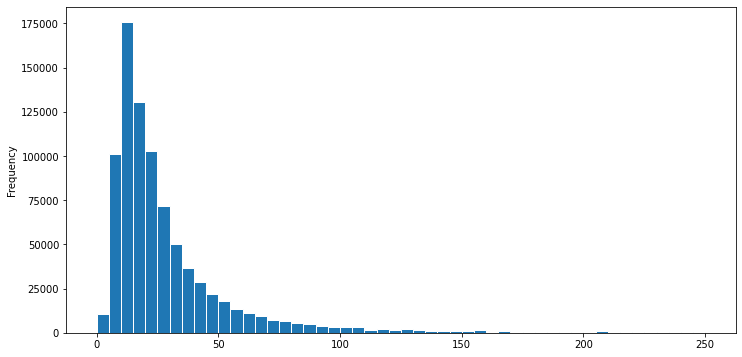

In [9]:
# sns.distplot( df_train["price"])
df["price"].plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])

The price of items are right skewed, vast majority of the items priced at 10–20. Thats why I will be doing log-transformation on the price.

<AxesSubplot:ylabel='Frequency'>

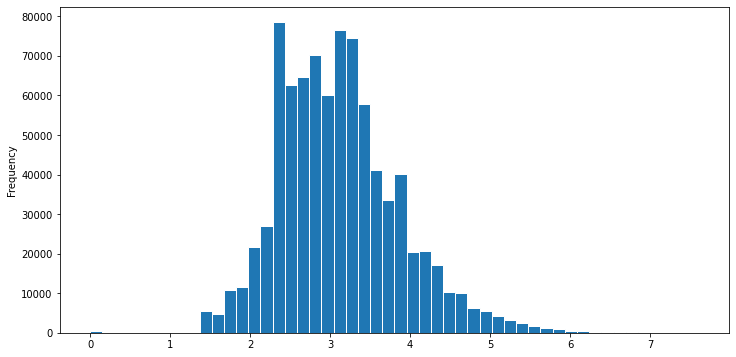

In [10]:
np.log(df['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')

In [11]:
# ax = sns.countplot(x="price",hue='category_name' , data=df_train)
df.category_name.nunique() # unique values in category name column

914

In [12]:
df.category_name.value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings    36456
Women/Tops & Blouses/T-Shirts                     32648
Beauty/Makeup/Face                                24706
Electronics/Video Games & Consoles/Games          19851
Beauty/Makeup/Lips                                18967
Women/Athletic Apparel/Shorts                     16844
Women/Underwear/Bras                              16058
Women/Tops & Blouses/Tank, Cami                   14570
Beauty/Makeup/Eyes                                13738
Men/Shoes/Athletic                                13458
Name: category_name, dtype: int64

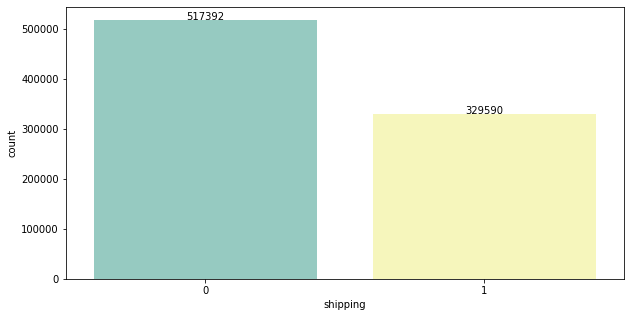

In [13]:
fig, ax1 = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax1,x='shipping', data=df,palette="Set3")
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

In [14]:
shipping_fee_by_buyer  = df.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = df.loc[df['shipping'] == 1, 'price']

In [15]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping')
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 27.12 if seller pays shipping
The average price is 33.34 if buyer pays shipping


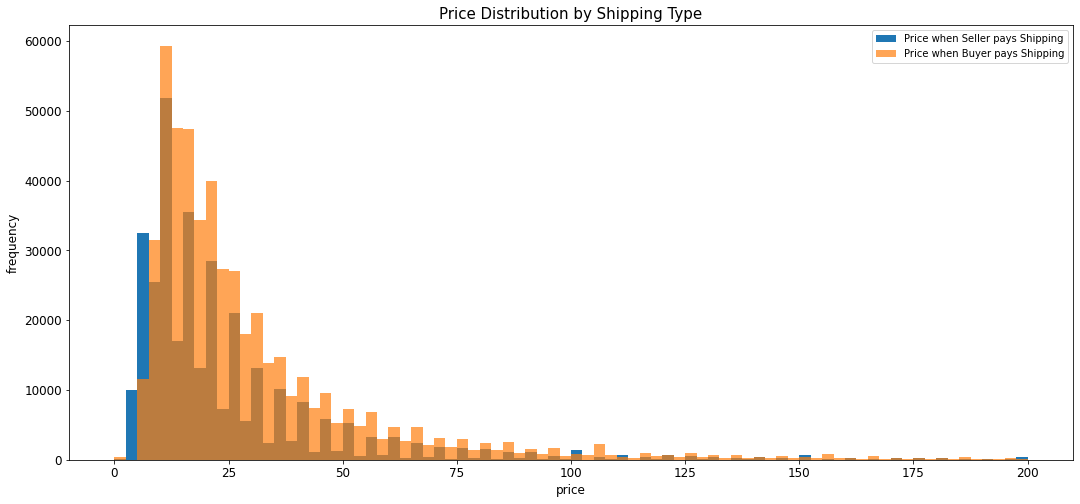

In [16]:
fig, ax = plt.subplots(figsize=(18,8))

ax.hist(shipping_fee_by_seller, alpha=1.0, bins=80, range = [0, 200],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, alpha=0.7, bins=80, range = [0, 200],
       label='Price when Buyer pays Shipping')

plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)

plt.tick_params(labelsize=12)
plt.legend()
plt.show()

Preprocessing on the item_description for analysis

In [23]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]','',text)
    text = text.strip(' ')
    return text

In [24]:
df['item_description'] = df['item_description'].map(lambda com : clean_text(com))

In [26]:
df['item_description'][1]

'this keyboard is in great condition and works like it came out of the box all of the ports are tested and work perfectly the lights are customizable via the razer synapse app on your pc'

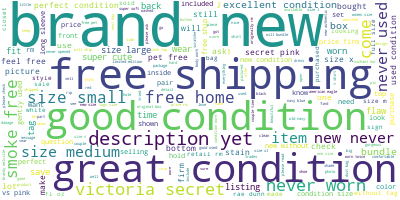

In [27]:
from wordcloud import WordCloud

# Create a WordCloud object
long_string = ','.join(list(df['item_description'].values))

# Generate a word cloud
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Visualize the word cloud
wordcloud.generate(long_string)
wordcloud.to_image()

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [87]:
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
import lightgbm as lgb
from scipy.sparse import hstack

In [69]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [93]:
df1 = np.random.rand(len(df)) < 0.8
X_train = df[df1]
X_test = df[~df1]

In [94]:
x_train, x_test = X_train.drop(['price'], axis=1), X_test.drop(['price'], axis=1)
y_train, y_test = X_train['price'], X_test['price']

In [95]:
y_train, y_test = X_train['price'], X_test['price']

In [96]:
from sklearn.preprocessing import OneHotEncoder

def onehot_encoding(feature):
    encoder = OneHotEncoder(handle_unknown='ignore')
    x_train_onehot = encoder.fit_transform(x_train[feature].values.reshape(-1,1))
    x_test_onehot = encoder.transform(x_test[feature].values.reshape(-1,1))
    return x_train_onehot, x_test_onehot
  
x_train_condition, x_test_condition = onehot_encoding('item_condition_id')
print(x_train_condition.shape, x_test_condition.shape)

(678167, 5) (168815, 5)


In [97]:
x_train_brand, x_test_brand = onehot_encoding('brand_name')
x_train_condition, x_test_condition = onehot_encoding('item_condition_id')
x_train_shipping, x_test_shipping = onehot_encoding('shipping')

In [98]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_train_name = cv.fit_transform(x_train['name'])
X_test_name = cv.fit_transform(x_test['name'])

cv = CountVectorizer()
X_train_category = cv.fit_transform(x_train['category_name'])
X_test_category = cv.fit_transform(x_test['category_name'])

tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_train_description = tv.fit_transform(x_train['item_description'])
X_test_description = tv.fit_transform(x_test['item_description'])

In [99]:
from scipy.sparse import hstack
x_train_final = hstack((x_train_brand,X_train_name,X_train_category, x_train_condition, x_train_shipping, X_train_description))

x_test_final = hstack((x_test_brand,X_test_name,X_test_category, x_test_condition, x_test_shipping, X_test_description))

print(x_train_final.shape, x_test_final.shape)

(678167, 66050) (168815, 60307)


In [100]:
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }